In [0]:
#Mount the google drive for storing the data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive/My Drive"

In [0]:
import os
os.chdir('gdrive/My Drive/traffic')  #change dir

In [0]:
# !mkdir train  #create a directory named train/
# !mkdir test  #create a directory named test/


In [0]:
# !unzip -q traffic-signs-preprocessed.zip -d train/  #unzip data in train/

In [0]:
!ls "/content/gdrive/My Drive/traffic/train"

In [0]:
# Data downloaded from The German Traffic Sign Recognition Benchmark:
# http://benchmark.ini.rub.de/?section=gtsrb&subsection=news

In [0]:
import os
cwd = os.getcwd()
cwd


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from PIL import Image
from skimage.transform import resize
from pylab import text
import csv

In [0]:
# Get names of every label class saved in a csv file. We have a total of 43 traffic sign labels.
def label_name(file):
    label_list = []
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            label_list.append(row[1])
        del label_list[0]
    return label_list

In [0]:
#Getting the data stored in pickle files. 
#The data is stored in dictionaries consisting of 4 keys: features, labels, sizes and coords.
def get_rgb_data(file):
    # Opening 'pickle' file and getting images
    with open(file, 'rb') as f: 
        d = pickle.load(f, encoding='latin1')
        x,y,s,c = d['features'].astype(np.float32), d['labels'], d['sizes'], d['coords'] 
    return x, y, s, c

In [0]:
# Features is a 4D array consisting of number of examples for each traffic sign type, its width, height and number of channels.
# Labels is a 1D array consisting of label id of the traffic sign image. There are total 43 traffic sign types and the label id matching is done 
# with the label names in label_names.csv
# Sizes is a 2D array which has the width and height of the image.
# Coords is a 2D array which denotes the bounding frame coordinates around the image,i.e.(x1,y1,x2,y2).

In [0]:
#Convert loaded data from rgb format to grayscale.
def rgb_to_gray_scale(x_data):
    x_g = np.zeros((x_data.shape[0], 1, 32, 32))
    x_g[:, 0, :, :] = x_data[:, 0, :, :] * 0.299 + x_data[:, 1, :, :] * 0.587 + x_data[:, 2, :, :] * 0.114
    return x_g

In [0]:
#We now define a function for getting a random image from the specified traffic sign label class.
def get_random_image(x_train, y_train, y_number):
    image_indexes = np.where(y_train == y_number)
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    return x_train[image_indexes][random_index]

In [0]:
#We define a function to rotate the image and also change the brightness of the rotated image
#https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html

def change_brightness_and_rotation(image):
    #Set angle rotation to 25
    angle_range = 25
    angle_rotation = np.random.uniform(angle_range) - angle_range / 2
    rows, columns, channels = image.shape
    affine_matrix = cv2.getRotationMatrix2D((columns / 2, rows / 2), angle_rotation, 1)
    #Lets rotate the image
    rotated_image = cv2.warpAffine(image, affine_matrix, (columns, rows))

    # Lets first convert the rotated image from RGB to HSV for changing its brightness 
    image_hsv = cv2.cvtColor(rotated_image, cv2.COLOR_RGB2HSV)
    # Assign random value for brightness change
    random_brightness = 0.25 + np.random.uniform()
    image_hsv[:, :, 2] = image_hsv[:, :, 2] * random_brightness
    # Lets convert the changed image back to RGB
    image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return image_rgb

In [0]:
# Now we create a function for equalization of the training datasets

def training_dataset_equalization(x_train, y_train):
    number_of_examples_for_every_label = np.bincount(y_train)
    number_of_labels = np.arange(len(number_of_examples_for_every_label))
    for i in number_of_labels:
        number_of_examples_to_add = int(np.mean(number_of_examples_for_every_label) * 2.5) - \
                                    number_of_examples_for_every_label[i]
        # Create two arrays for storing the new images
        x_temp = []
        y_temp = []
        for j in range(number_of_examples_to_add):
            getting_random_image = get_random_image(x_train, y_train, i)
            x_temp.append(change_brightness_and_rotation(getting_random_image))
            y_temp.append(i)
        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)
    return x_train, y_train

In [0]:
# Creating a function for changing the contrast of the images by performing Local Histogram Equalization 
# on the given imageset. We use openCV libraries for doing this.
#Ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
def local_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    return clahe.apply(image)

In [0]:
# Now we define the data preprocessing part, whenever new a dataset is introduced, it is preprocessed by applying 
# transformations on the datasets as per the parameters being input.
from sklearn.utils import shuffle
def data_preprocessing(d, shuffle=False, lhe=False, norm_255=False, mean_norm=False, std_norm=False,
                    transpose=True, colour='rgb'):
    #If shuffle is set to true, then shuffle the dataset to generate randomized data
    if shuffle:
        np.random.seed(0)
        np.random.shuffle(d['x_train'])
        np.random.seed(0)
        np.random.shuffle(d['y_train'])
        np.random.seed(0)
        np.random.shuffle(d['x_test'])
        np.random.seed(0)
        np.random.shuffle(d['y_test'])
        np.random.seed(0)
        np.random.shuffle(d['x_validation'])
        np.random.seed(0)
        np.random.shuffle(d['y_validation'])

    #If Local Histogram Equalization is is set to true, then apply Local Histogram Equalization on the data
    if lhe:
        d['x_train'] = list(map(local_histogram_equalization, d['x_train'][:, 0, :, :].astype(np.uint8)))
        d['x_train'] = np.array(d['x_train'])
        d['x_train'] = d['x_train'].reshape(d['x_train'].shape[0], 1, 32, 32)
        d['x_train'] = d['x_train'].astype(np.float32)
        d['x_test'] = list(map(local_histogram_equalization, d['x_test'][:, 0, :, :].astype(np.uint8)))
        d['x_test'] = np.array(d['x_test'])
        d['x_test'] = d['x_test'].reshape(d['x_test'].shape[0], 1, 32, 32)
        d['x_test'] = d['x_test'].astype(np.float32)
        d['x_validation'] = list(map(local_histogram_equalization, d['x_validation'][:, 0, :, :].astype(np.uint8)))
        d['x_validation'] = np.array(d['x_validation'])
        d['x_validation'] = d['x_validation'].reshape(d['x_validation'].shape[0], 1, 32, 32)
        d['x_validation'] = d['x_validation'].astype(np.float32)

    # If norm255 is is set to true, then we apply Normalization on the data by dividing by 255.0.
    if norm_255:
        d['x_train'] = d['x_train'].astype(np.float32) / 255.0
        d['x_validation'] /= 255.0
        d['x_test'] /= 255.0
        mean_image = np.mean(d['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)
        dictionary = {'mean_image_' + colour: mean_image}
        with open('mean_image_' + colour + '.pickle', 'wb') as f_mean_image:
            pickle.dump(dictionary, f_mean_image)
        #Now lets calculate the standard deviation from the training dataset along the rows by specifying 'axis=0'
        std = np.std(d['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)
        dictionary = {'std_' + colour: std}
        with open('std_' + colour + '.pickle', 'wb') as f_std:
            pickle.dump(dictionary, f_std)

    # By calculating the mean image, and subtracting it from the dataset, we now normalize the data.
    if mean_norm:
        with open('mean_image_' + colour + '.pickle', 'rb') as f:
            mean_image = pickle.load(f, encoding='latin1')
        d['x_train'] -= mean_image['mean_image_' + colour]
        d['x_test'] -= mean_image['mean_image_' + colour]
        d['x_validation'] -= mean_image['mean_image_' + colour]

    # Applying Standard Normalization by dividing with the standard deviation
    if std_norm:
        with open('std_' + colour + '.pickle', 'rb') as f:
            std = pickle.load(f, encoding='latin1')

        d['x_train'] /= std['std_' + colour]
        d['x_test'] /= std['std_' + colour]
        d['x_validation'] /= std['std_' + colour]

    if transpose:
        # This will transpose every dataset to make the channels come first
        d['x_train'] = d['x_train'].transpose(0, 3, 1, 2)
        d['x_test'] = d['x_test'].transpose(0, 3, 1, 2)
        d['x_validation'] = d['x_validation'].transpose(0, 3, 1, 2)

    return d


In [0]:
#I have loaded and preprocessed data for rgb and grayscale separately
# Step 1 - rgb data --> starts here


In [0]:
# Lets load rgb data from the original training, validation and testing datasets and getting label names from 'label_names.csv' file
x_train, y_train, s_train, c_train = get_rgb_data('/content/gdrive/My Drive/traffic/train/train.pickle')
x_validation, y_validation, s_validation, c_validation = get_rgb_data('/content/gdrive/My Drive/traffic/train/valid.pickle')
x_test, y_test, s_test, c_test = get_rgb_data('/content/gdrive/My Drive/traffic/train/test.pickle')
label_list = label_name('/content/gdrive/My Drive/traffic/train/label_names.csv')


In [0]:
#Lets implement equalization of training dataset. Equalization is done only for the training datasets.

x_train, y_train = training_dataset_equalization(x_train.astype(np.uint8), y_train)


In [0]:
#Now lets store the equalized data from the previous step into a dictionary

d_loaded = {'x_train': x_train, 'y_train': y_train,
            'x_validation': x_validation, 'y_validation': y_validation,
            'x_test': x_test, 'y_test': y_test,
            'labels': label_list}

In [0]:
# Now lets apply different preprocessing functions on each of the pickle files
# Apply basic shuffling and transposing the images in data0.pickle. This data0.pickle file is then reused, transformed by 
# using different methods and stored in different pickle files.
# We have to run this only once, as the data0 is shuffled and transposed just once, further operations are carried out 
# on this modified data.

data0 = data_preprocessing(d_loaded, shuffle=True, transpose=True)
print(data0['x_train'][0, 0, :, 0])
#Saving loaded and preprocessed data into a 'pickle' file
with open('/content/gdrive/My Drive/traffic/train/data0.pickle', 'wb') as f:
    pickle.dump(data0, f)
del data0

[ 96  98  98  96  98 104 105 105 105 105 102  91  74  83  99  94 101 103
 100  85  89  92  98  98  90  82  99  87  86  50  56  42]


In [0]:
# 'New_Pickle1' Generation: Loading 'data0.pickle' dataset and perform basic normalization and mean normalization on it.
# Opening file for reading in binary mode
with open('/content/gdrive/My Drive/traffic/train/data0.pickle', 'rb') as f:
    d_0_1 = pickle.load(f, encoding='latin1')  # dictionary type
data1 = data_preprocessing(d_0_1, shuffle=False, norm_255=True, mean_norm=True, transpose=False,
                        colour='rgb')
# Saving loaded and preprocessed data into 'pickle' file
with open('/content/gdrive/My Drive/traffic/train/data1.pickle', 'wb') as f:
    pickle.dump(data1, f)
del d_0_1
del data1

In [0]:
# 'New_Pickle2' Generation: Loading 'data0.pickle' dataset and basic normalization, standard normalization and mean normalization on it.
# Opening file for reading in binary mode
with open('/content/gdrive/My Drive/traffic/train/data0.pickle', 'rb') as f:
    d_0_2 = pickle.load(f, encoding='latin1')  # dictionary type
data2 = data_preprocessing(d_0_2, shuffle=False, norm_255=True, mean_norm=True, std_norm=True,
                        transpose=False, colour='rgb')
# Saving loaded and preprocessed data into 'pickle' file
with open('/content/gdrive/My Drive/traffic/train/data2.pickle', 'wb') as f:
    pickle.dump(data2, f)
del d_0_2
del data2

# Step 1 - rgb data --> ends here

In [0]:
# Step 2 - grayscale data --> starts here
# Loading 'data0.pickle' rgb dataset and going further with it
# Opening file for reading in binary mode
with open('/content/gdrive/My Drive/traffic/train/data0.pickle', 'rb') as f:
    data0 = pickle.load(f, encoding='latin1')  # dictionary type

# Converting rgb data to grayscale for training dataset
x_train = rgb_to_gray_scale(data0['x_train'])

# Converting rgb data to grayscale for testing dataset
x_test = rgb_to_gray_scale(data0['x_test'])

# Converting rgb data to grayscale for validation dataset
x_validation = rgb_to_gray_scale(data0['x_validation'])




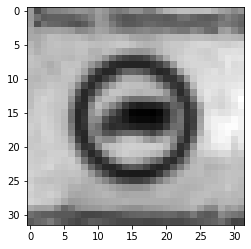

In [0]:
# Putting loaded grayscale data into the dictionary
d_loaded_gray = {'x_train': x_train, 'y_train': data0['y_train'],
                 'x_validation': x_validation, 'y_validation': data0['y_validation'],
                 'x_test': x_test, 'y_test': data0['y_test'],
                 'labels': data0['labels']}

# Showing the image by using obtained array with only one channel
plt.imshow(x_train[9000, 0, :, :].astype(np.uint8), cmap=plt.get_cmap('gray'))
plt.show()

In [0]:
# Saving loaded and preprocessed grayscale data into 'data_gray.pickle' file
with open('/content/gdrive/My Drive/traffic/train/data_gray.pickle', 'wb') as f:
    pickle.dump(d_loaded_gray, f)
# Releasing memory
del d_loaded_gray

In [0]:
# 'New_Pickle3' Generation: Loading 'data_gray.pickle' dataset and perform basic normalization, mean normalization 
# and Local histogram equalization on it.
# Loading 'data_gray.pickle' dataset and going further with it
# Opening file for reading in binary mode

with open('/content/gdrive/My Drive/traffic/train/data_gray.pickle', 'rb') as f:
    d_0_3 = pickle.load(f, encoding='latin1')  # dictionary type

data3 = data_preprocessing(d_0_3, shuffle=False, lhe=True, norm_255=True, mean_norm=True, std_norm=True,
                        transpose=False, colour='gray')
# Saving loaded and preprocessed data into 'pickle' file
with open('/content/gdrive/My Drive/traffic/train/data3.pickle', 'wb') as f:
    pickle.dump(data3, f)
# Releasing memory
del d_0_3
del data3



In [0]:
# Applying preprocessing
# 'New_Pickle4' Generation: Loading 'data_gray.pickle' dataset and perform basic normalization, 
#standard normalization, mean normalization and Local histogram equalization on it.
# Opening file for reading in binary mode

with open('/content/gdrive/My Drive/traffic/train/data_gray.pickle', 'rb') as f:
    d_0_4 = pickle.load(f, encoding='latin1')  # dictionary type

data4 = data_preprocessing(d_0_4, shuffle=False, lhe=True, norm_255=True, mean_norm=True, std_norm=True,
                        transpose=False, colour='gray')
# Saving loaded and preprocessed data into 'pickle' file
with open('/content/gdrive/My Drive/traffic/train/data4.pickle', 'wb') as f:
    pickle.dump(data4, f)
# Releasing memory
del d_0_4
del data4

In [0]:
# Now we are done with pre processing the data with different transformations and have stored them in 4 different pickle files.
# Two of them are in RGB format while two are in Grayscale. 